In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

plt.style.use('ggplot')

## Описание эксперимента
Перед вами таблица, где числовая переменная – непрерывная. Задача – сравнить группы двумя способами: бутстрапом и u-тестом  
Описание колонок
value – значения метрики
experimentVariant – Вариант теста (Control – контроль, Treatment – тест)
### Задача
1. Сравните результат между тестом и контролем по двум кейсам:  
Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value  
Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value.  
2. Напишите выводы, которые можно сделать на основе анализа примененных критериев  

In [2]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [3]:
#Загружаем файл с данными эксперимента
exp = pd.read_csv('https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv', sep=';', index_col='Unnamed: 0')
exp

,value,experimentVariant
1,"10,3804953740268",Control
2,"9,54686666784264",Control
3,"11,0882146509904",Control
4,"10,1472740570122",Control
5,"9,78980767524929",Control
...,...,...
996,1000,Treatment
997,1200,Treatment
998,1500,Treatment
999,2000,Treatment


In [4]:
# Проверяем наличие дыр в данных
exp.isna().sum()

value                0
experimentVariant    0
dtype: int64

In [5]:
# Проверяем тип столбцов
exp.rename(columns={'experimentVariant': 'experiment_variant'}, inplace=True)
exp.dtypes

value                 object
experiment_variant    object
dtype: object

In [6]:
# Переводим числовые данные из str формата в float
exp['value'] = exp['value'].str.replace(',', '.')
exp['value'] = exp.value.astype('float')

In [7]:
# Разделяем целый датафрейм на тестовую и контрольную группы
test = exp[exp['experiment_variant'] == 'Treatment']['value']
control = exp[exp['experiment_variant'] == 'Control']['value']

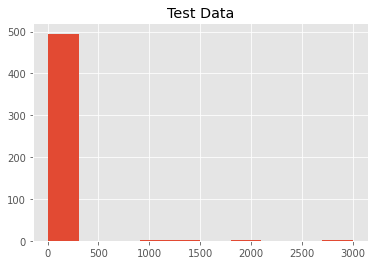

In [8]:
# График распределения тестовой группы
plt.title('Test Data')
test.hist()

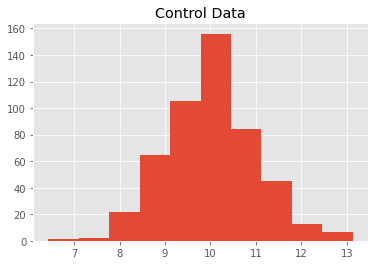

In [9]:
# График распределения контрольной группы
plt.title('Control Data')
control.hist()

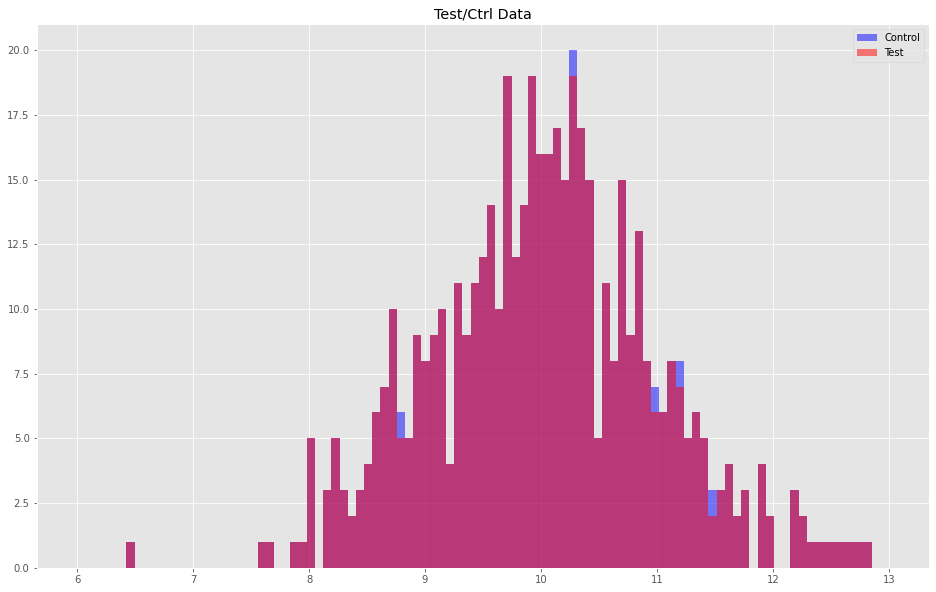

In [10]:
# График пересечения тестовой и контрольных групп в диапазоне значений (6, 13)
bins = np.linspace(6, 13, 100)
plt.figure(figsize=(16, 10))
plt.hist(control, bins=bins, label='Control', color='blue', alpha=0.5)
plt.hist(test, bins=bins, label='Test', color='red', alpha=0.5)
plt.title('Test/Ctrl Data')
plt.legend()

Оценивая данные по трем графикам, мы можем сказать о схожести распределения тестовой и контрольной группы. На последнем графике видно, что их распределения очень схожи и практически пересекаются  
Контрольная группа в основном отличается от тестового наличием выбросов со значениями 1000+

In [15]:
test

501       10.380495
502        9.546867
503       11.088215
504       10.147274
505        9.789808
           ...     
996     1000.000000
997     1200.000000
998     1500.000000
999     2000.000000
1000    3000.000000
Name: value, Length: 500, dtype: float64

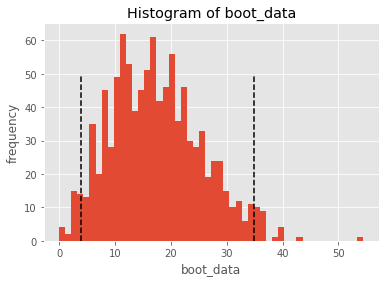

In [11]:
# Получаем бутстрапированное распределение разницы тестовой и контрольной группы с помощью средних значений
bootstrap_mean = get_bootstrap(test, control, statistic = np.mean)
bootstrap_mean
plt.show()

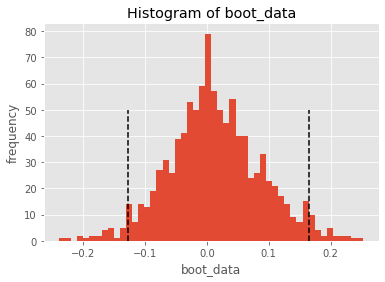

In [12]:
# Получаем бутстрапированное распределение разницы тестовой и контрольной группы с помощью медианны
bootstrap_median = get_bootstrap(test, control, statistic = np.median)
bootstrap_median
plt.show()

In [13]:
# Сравнениваем выборки критерием Манна-Уитни
whineyu = mannwhitneyu(control, test)
whineyu

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

In [14]:
# p-value разных методов
print('bootstrap_mean', bootstrap_mean['p_value'])
print('bootstrap_median', bootstrap_median['p_value'])
print(whineyu)

bootstrap_mean 0.03166777594783749
bootstrap_median 0.8648993304943869
MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)


### Выводы:

При сравнении групп с помощью бутстрапа с центральной тендценцией в виде среднего значения мы получаем разный уровень значимости по сравнению с результатами критерия Манна-Уитни. В первом случае есть статистически значимые различия, а в другом группы почти не отличаются друг от друга  
Но если использовать бутстрап с медианной центральной тенденцией получается иной результат, который практически совпадает со значениями критерия Манна-Уитни

На этом примере мы убеждаемся почему нельзя использовать методы, которые используют средние значения при наличии сильных выбросов. Если данные контрольных и тестовых групп находятся в одной области и практически полностью пересекаются, наличие заметных аномалий в данных будут портить результаты, где мы видим как бутстрап с использованиемм среденго значения находит статистически значимые различия в этих группах  

А бутстрап с использованием медианны и непараметрический критерий Манна-Уитни, которые не чувствительны к выбросам не выявили в схожих группах различие и даже получили довольно схожие значения уровня значимости